In [1]:
import scipy
import numpy as np
from fitters import *
from tools import *
from plots import *
from projectors import *
set_seaborn({'figure.figsize': (12,8)})
%load_ext autoreload
%autoreload 2


In [2]:
resPH, stimPH = read_lmc('PHOTO')
res1, stim3 = read_lmc('LMC-BG1')
res2, stim3 = read_lmc('LMC-BG2')
res3, stim3 = read_lmc('LMC-BG3')
res4, stim4 = read_lmc('LMC-BG4')
res5, stim5 = read_lmc('LMC-BG5')
res6, stim6 = read_lmc('LMC-BG6')

TIME = 1.0
all_results = []

In [3]:
def get_data(Ydataset, factor, Xdataset='PHOTO'):
    resX, stim = read_lmc(Xdataset)
    resY, stim = read_lmc(Ydataset)
    X = preprocess(resX, factor=factor, method='mean')
    Y = preprocess(resY, factor=factor, method='mean')

    return X, Y


In [4]:
def convert_dtms_windowms_to_factor_dim(dt, window, TIME=1.0, LEN=10000):
    orignal_dt_ms = TIME/LEN * 1000
    factor = int(dt/orignal_dt_ms)
    dim = int(window / dt)
    return factor, dim


In [5]:

def test_run(beta=0, dt_ms=1.0, lag_ms=50, method='eig', top_i=1, dataset='', window_factor=2.0):

    factor, dim = convert_dtms_windowms_to_factor_dim(dt_ms, lag_ms)
    X_series, Y_series = get_data(dataset, factor)

    time = np.linspace(0, 1, len(X_series))

    if method == 'eig':
        Xhan = build_hankel(X_series, dim)
        X0 = Xhan[:, :-1]
        Xp = Xhan[:, 1:]
        lam = beta * np.eye(dim)

        X0Xp = X0 @ Xp.T
        X0X0 = X0 @ X0.T
        # solve eigenvalue problem
        w, vl = scipy.linalg.eig(X0Xp, (X0X0+lam))

        sortorder = np.argsort(w)
        thetas = vl[:, sortorder][:, ::-1]
        # theta = thetas[:, -2]
        w = w[sortorder][::-1]

        thetas[:, :top_i] *= thetas[:, :top_i][-1]
        theta = np.mean(thetas[:, :top_i], axis=-1)

        P_series = theta.real @ Xhan

    elif method == 'eig-comp':
        Xhan = build_hankel(X_series, dim)
        X0 = Xhan[:, :-1]
        Xp = Xhan[:, 1:]
        Xp = Xp[-1]
        lam = beta * np.eye(dim)

        a = (Xp @ X0.T) @ np.linalg.inv((X0 @ X0.T) + lam)
        A = np.eye(dim, k=1)
        A[-1] = a
        w, vl = scipy.linalg.eig(A, left=True, right=False)

        sortorder = np.argsort(w)
        thetas = vl[:, sortorder][:, ::-1]
        # theta = thetas[:, -2]
        w = w[sortorder][::-1]

        thetas[:, :top_i] *= thetas[:, :top_i][-1]
        theta = np.mean(thetas[:, :top_i] * w[:top_i], axis=-1)

        P_series = theta.real @ Xhan

    elif method == 'eig-C':
        P_series, theta, A, c = eig_companion_Cshift(X_series, dim, beta=beta)

    elif method == 'eig-C-TIME':
        P_series, theta = eig_companion_Cshift_time(
            X_series, dim, beta=beta, window_factor=window_factor)

    elif method == 'eig-TIME':
        P_series, theta = eig_companion_time(
            X_series, dim, beta=beta, window_factor=window_factor)


    elif method == 'PredCoding':
        Xhan = build_hankel(X_series, dim)
        X0 = Xhan[:-1]
        Xp = Xhan[-1:]

        lam = beta * np.eye(dim-1)

        a = (Xp @ X0.T) @ np.linalg.inv((X0 @ X0.T) + lam)
        theta = np.concatenate((-a,1), axis=None)
        theta /= theta[-1]
        P_series = theta @ Xhan


    elif method == 'PredCodingWindow':

        N = len(X_series)
        window = int(dim * window_factor)
        thetas = []
        for i in range(window, N, 1):
            sl = slice(i-window, i)
            Xhan = build_hankel(X_series[sl], dim)
            X0 = Xhan[:-1]
            Xp = Xhan[-1:]
            lam = beta * np.eye(dim-1)
            a = (Xp @ X0.T) @ np.linalg.inv((X0 @ X0.T) + lam)
            theta = np.concatenate((-a,1), axis=None)
            theta /= theta[-1]
            P_series = theta @ Xhan
            thetas.append(theta)

        Xhan = build_hankel(X_series, dim)
        theta = np.mean(thetas, axis=0)
        P_series = theta.real @ Xhan


    elif method == 'svd':
        Xhan = build_hankel(X_series, dim)
        X0 = Xhan[:, :-1]
        Xp = Xhan[:, 1:]
        Xp = Xp[-1]
        lam = beta * np.eye(dim)

        a = (Xp @ X0.T) @ np.linalg.inv((X0 @ X0.T) + lam)
        A = np.eye(dim, k=1)
        A[-1] = a

        U, s, Vh = scipy.linalg.svd(A)
        theta = Vh[0, :]
        P_series = theta @ Xhan



    elif method == 'constant':
        # dim = 1
        # Xhan = build_hankel(X_series, dim)
        # theta = np.ones(dim)
        P_series = X_series[dim:]
        theta = np.ones(dim)


    elif method == 'DMD':
        Xhan = build_hankel(X_series, dim)
        X0 = Xhan[:, :-1]
        Xp = Xhan[:, 1:]
        r = dim // 2
        u, s, v = np.linalg.svd(X0, full_matrices=False)
        u, s, v = u[:, :r], s[:r], v[:r, :]

        s_inv = np.diag(1/s)

        A = u.conj().T @ Xp @ v.conj().T @ s_inv
        w, vl = scipy.linalg.eig(A, left=True, right=False)

        largest_evec_hat = vl[:, np.nanargmax(w)]
        theta = u @ largest_evec_hat
        P_series = theta.real @ Xhan

    Y_series = Y_series[dim:]
    P_series = solve_scale_shift(P_series, Y_series)

    err = mean_square_error(Y_series, P_series)  # / np.linalg.norm(Y_series)

    result = {
        'Time-X': time,
        'Time-Y': time[dim:],
        'Time-Filter': np.linspace(-lag_ms, 0, dim),
        'Theta (REAL)': theta.real,
        'Theta (IMAG)': theta.imag,
        'X_series': X_series,
        'Y_series': Y_series,
        'P_series': P_series,
        'MSE': err
    }
    return result


In [67]:
ALL_DATA = ['LMC-BG1', 'LMC-BG2', 'LMC-BG3', 'LMC-BG4', 'LMC-BG5', 'LMC-BG6']
lag_msS = np.arange(20,60,10)
params = {
    'dataset': ['LMC-BG1'],
    'beta': [1e-3, 1e-4, 1e-5],
    'window_factor': [2, 2.5, 3],
    'dt_ms': [2.0, 3.0],
    'lag_ms': lag_msS,
    'method': ['constant', 'eig-TIME', 'eig-C-TIME', 'DMD'],

}
results = param_runner(test_run, params)


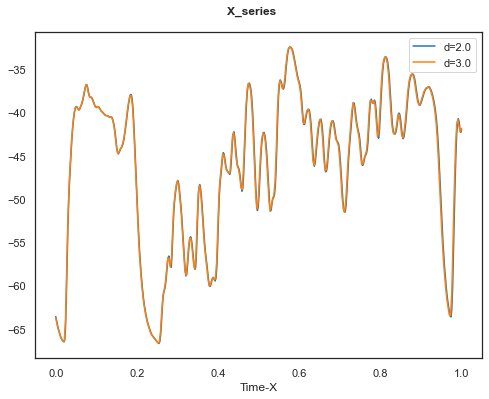

/usr/local/lib/python3.9/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


ValueError: operands could not be broadcast together with shapes (10,) (6,) 

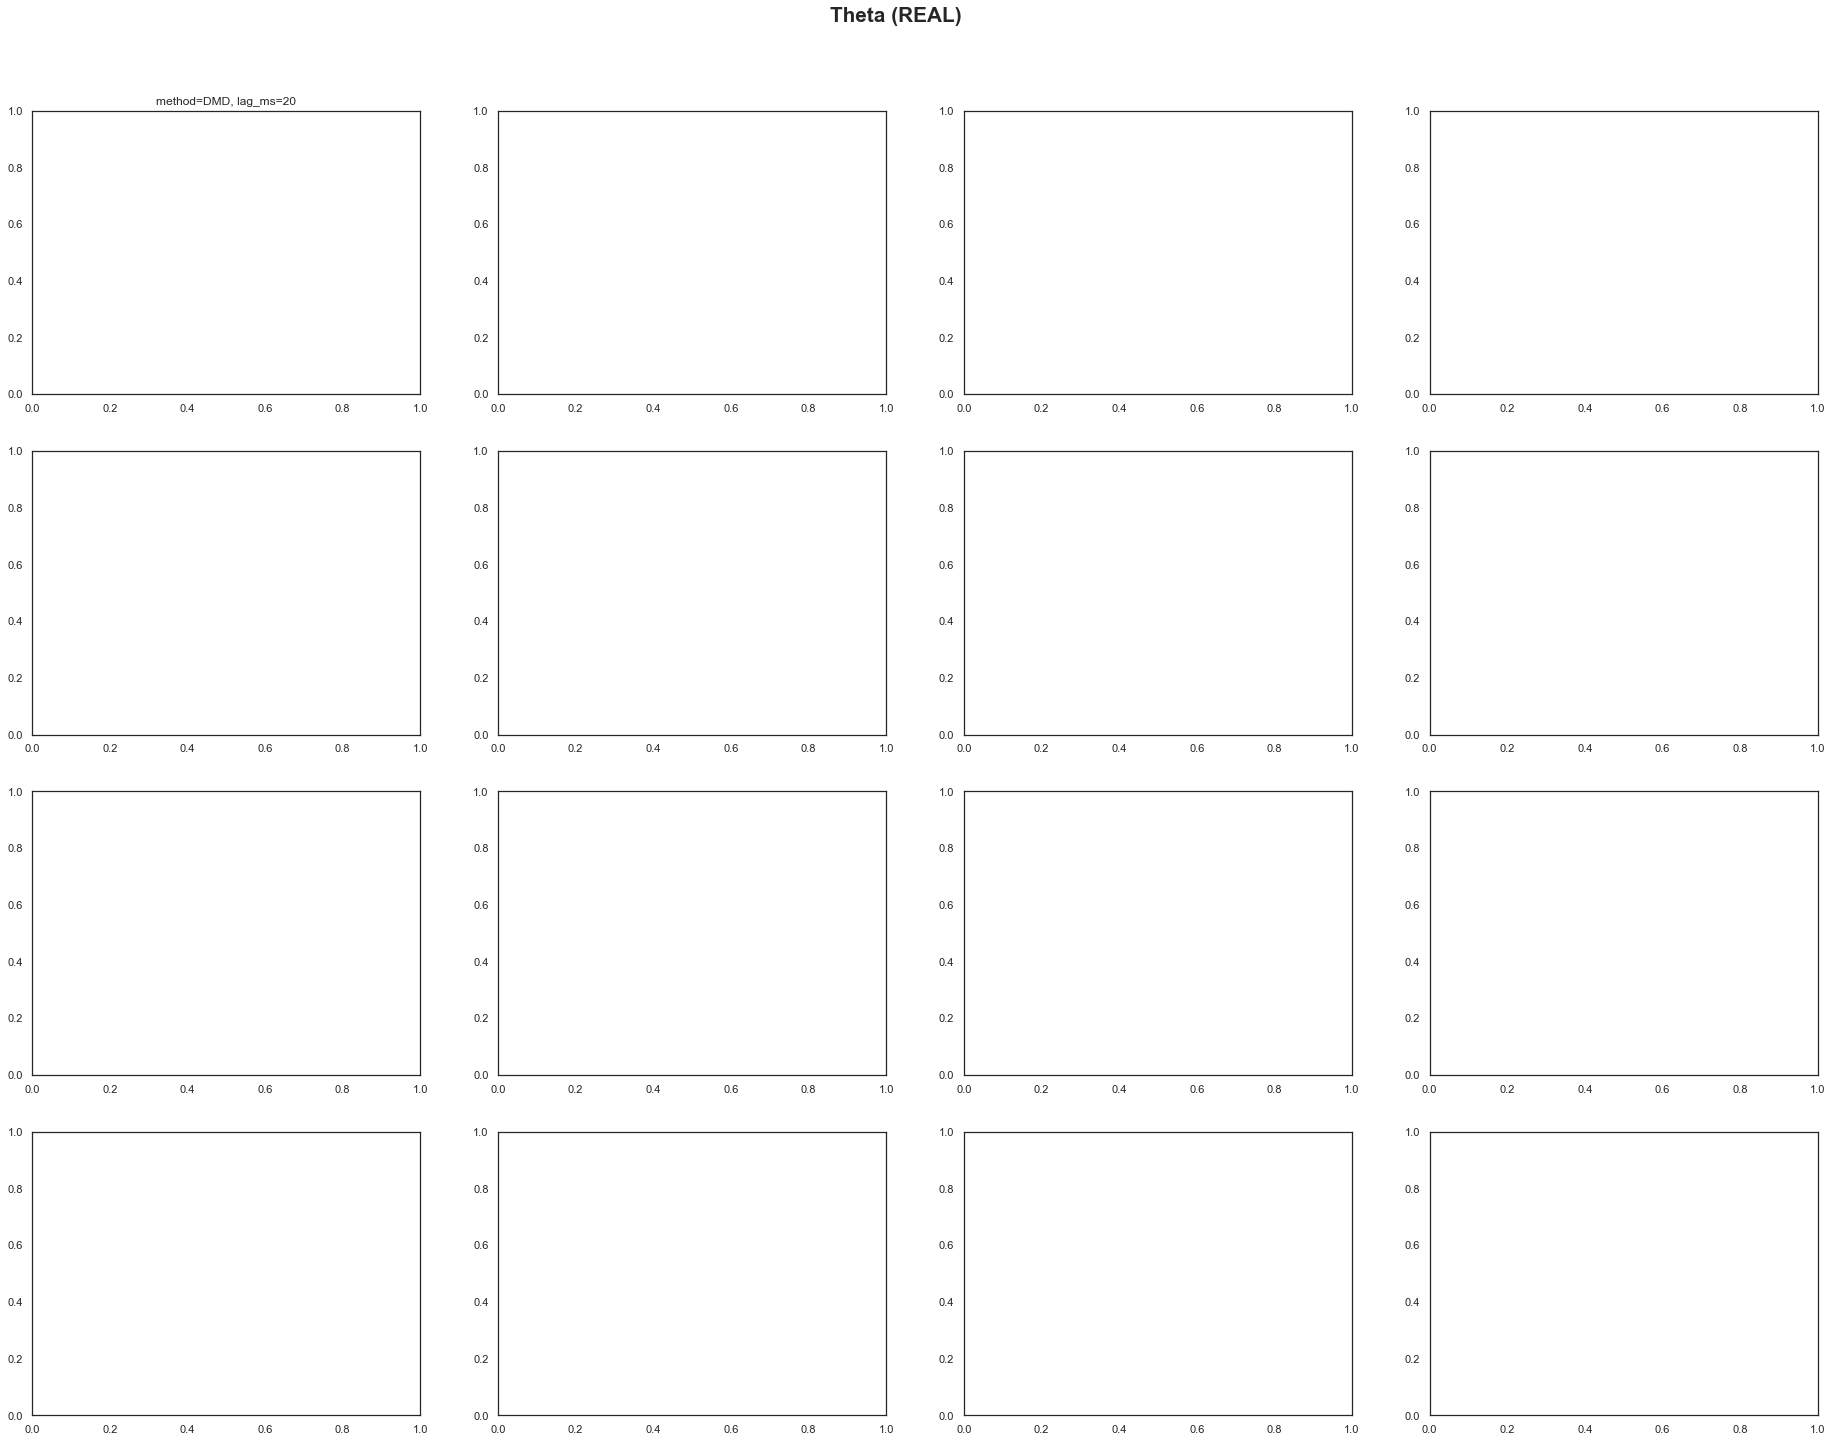

In [68]:
plot_dataframe(results, 'X_series', x_col='Time-X', line_cols='dt_ms')
plot_dataframe(results, 'Theta (REAL)',  title_cols=[ 'method',  'lag_ms'], val_styles=[['.-']])
plot_dataframe(results, 'Theta (REAL)',x_col='Time-Filter', title_cols=[ 'method','lag_ms','dt_ms'])


In [ ]:
fig = plt.figure()
fig.su

In [543]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.font_manager import font_scalings, weight_dict

# helper function to deal with empty array grouping and to auto make labels


def group_by(dataframe, cols):
    dfs, labels = [], []
    if len(cols) > 0 and cols is not None:
        grouped = dataframe.groupby(cols)
        for (vals, group) in grouped:
            vals = arr_if_scalar(vals)
            # build label by group vals
            label = ', '.join([f'{k}={v}' for k, v in zip(cols, vals)])
            dfs.append(group)
            labels.append(label)
    else:
        dfs.append(dataframe)
        labels.append('')

    return dfs, labels


def get_hw_from_cols(df, cols):
    # makes first title col vary by row
    d1, d2 = 1, 1
    if len(cols) == 1:
        n = len(pd.unique(df[cols[0]]))
        return factor_int_close_to_square(n)

    for i, t in enumerate(cols):
        n = len(pd.unique(df[t]))
        if i == 0:
            d1 *= n
        else:
            d2 *= n
    return d1, d2


def flatten(a):
    return a.flat if hasattr(a, 'flat') else [a]


def plot_dataframe3(df, plotter, layers=[[]], size=(8, 6), figures=True, sharex=True, sharey=True, stroke=True, title=' ', colors=None):

    # preprocess so always arr of arrs
    layers = [arr_if_scalar(l) for l in layers]

    # globals
    N_nest = len(layers)
    layers.append(None)  # add dummy
    weights = ['black', 'bold', 'medium', 'normal', 'light']
    sizes = ['xx-large', 'x-large', 'large', 'medium', 'small']
    if colors is None:
        colors = [str(i) for i in np.linspace(0.86, 1.0, N_nest+1)]
    hws = set()

    def build_fig_group(df, fig, label, cols, depth, hws):

        if depth == N_nest:
            ax = fig  # at bottom if is an ax
            ax.set_title(label)
            plotter(df, ax)
            return hws

        # configure fig
        fig.suptitle(
            f'{label}', fontsize=sizes[depth-1], fontweight=weights[depth-1])
        fig.set_facecolor(colors[depth])

        if stroke:
            fig.set_linewidth(1)
            fig.set_edgecolor('black')

        # get sub grid dims
        h, w = get_hw_from_cols(df, cols)
        hws.add((h, w, depth))

        # final layer needs to bulil ax instead of subfig
        if depth == N_nest - 1:
            subfigs = fig.subplots(h, w, sharex=sharex, sharey=sharey)
        else:
            subfigs = fig.subfigures(h, w)
        subfigs = flatten(subfigs)

        dfs, labels = group_by(df, cols)
        for i in range(len(dfs)):
            hws = build_fig_group(dfs[i], subfigs[i],
                                  labels[i], layers[depth+1], depth+1, hws)

        return hws

    def set_hw(hws, fig):
        H, W = 1, 1
        for (h, w, _) in hws:
            H, W = H*h, W*w
        W = size[0]*W
        H = size[1]*H + 1.35*H  # extra for title room
        fig.set_size_inches(W, H)
        return H, W

    depth = 0
    layout = {'w_pad': 0.2, 'h_pad': 0.2}
    margin = 1
    if figures:
        dfs, labels = group_by(df, layers[depth])
        for i in range(len(dfs)):
            fig = plt.figure(constrained_layout=True)
            hws = build_fig_group(
                dfs[i], fig, labels[i], layers[depth+1], depth+1, set())
            H, W = set_hw(hws, fig)
            fig.set_constrained_layout_pads(
                **layout, hspace=margin/H, wspace=margin/W)
    else:
        fig = plt.figure(constrained_layout=True)
        hws = build_fig_group(df, fig, title, layers[depth], depth, set())
        H, W = set_hw(hws, fig)
        fig.set_constrained_layout_pads(
            **layout, hspace=margin/H, wspace=margin/W)
    plt.show()


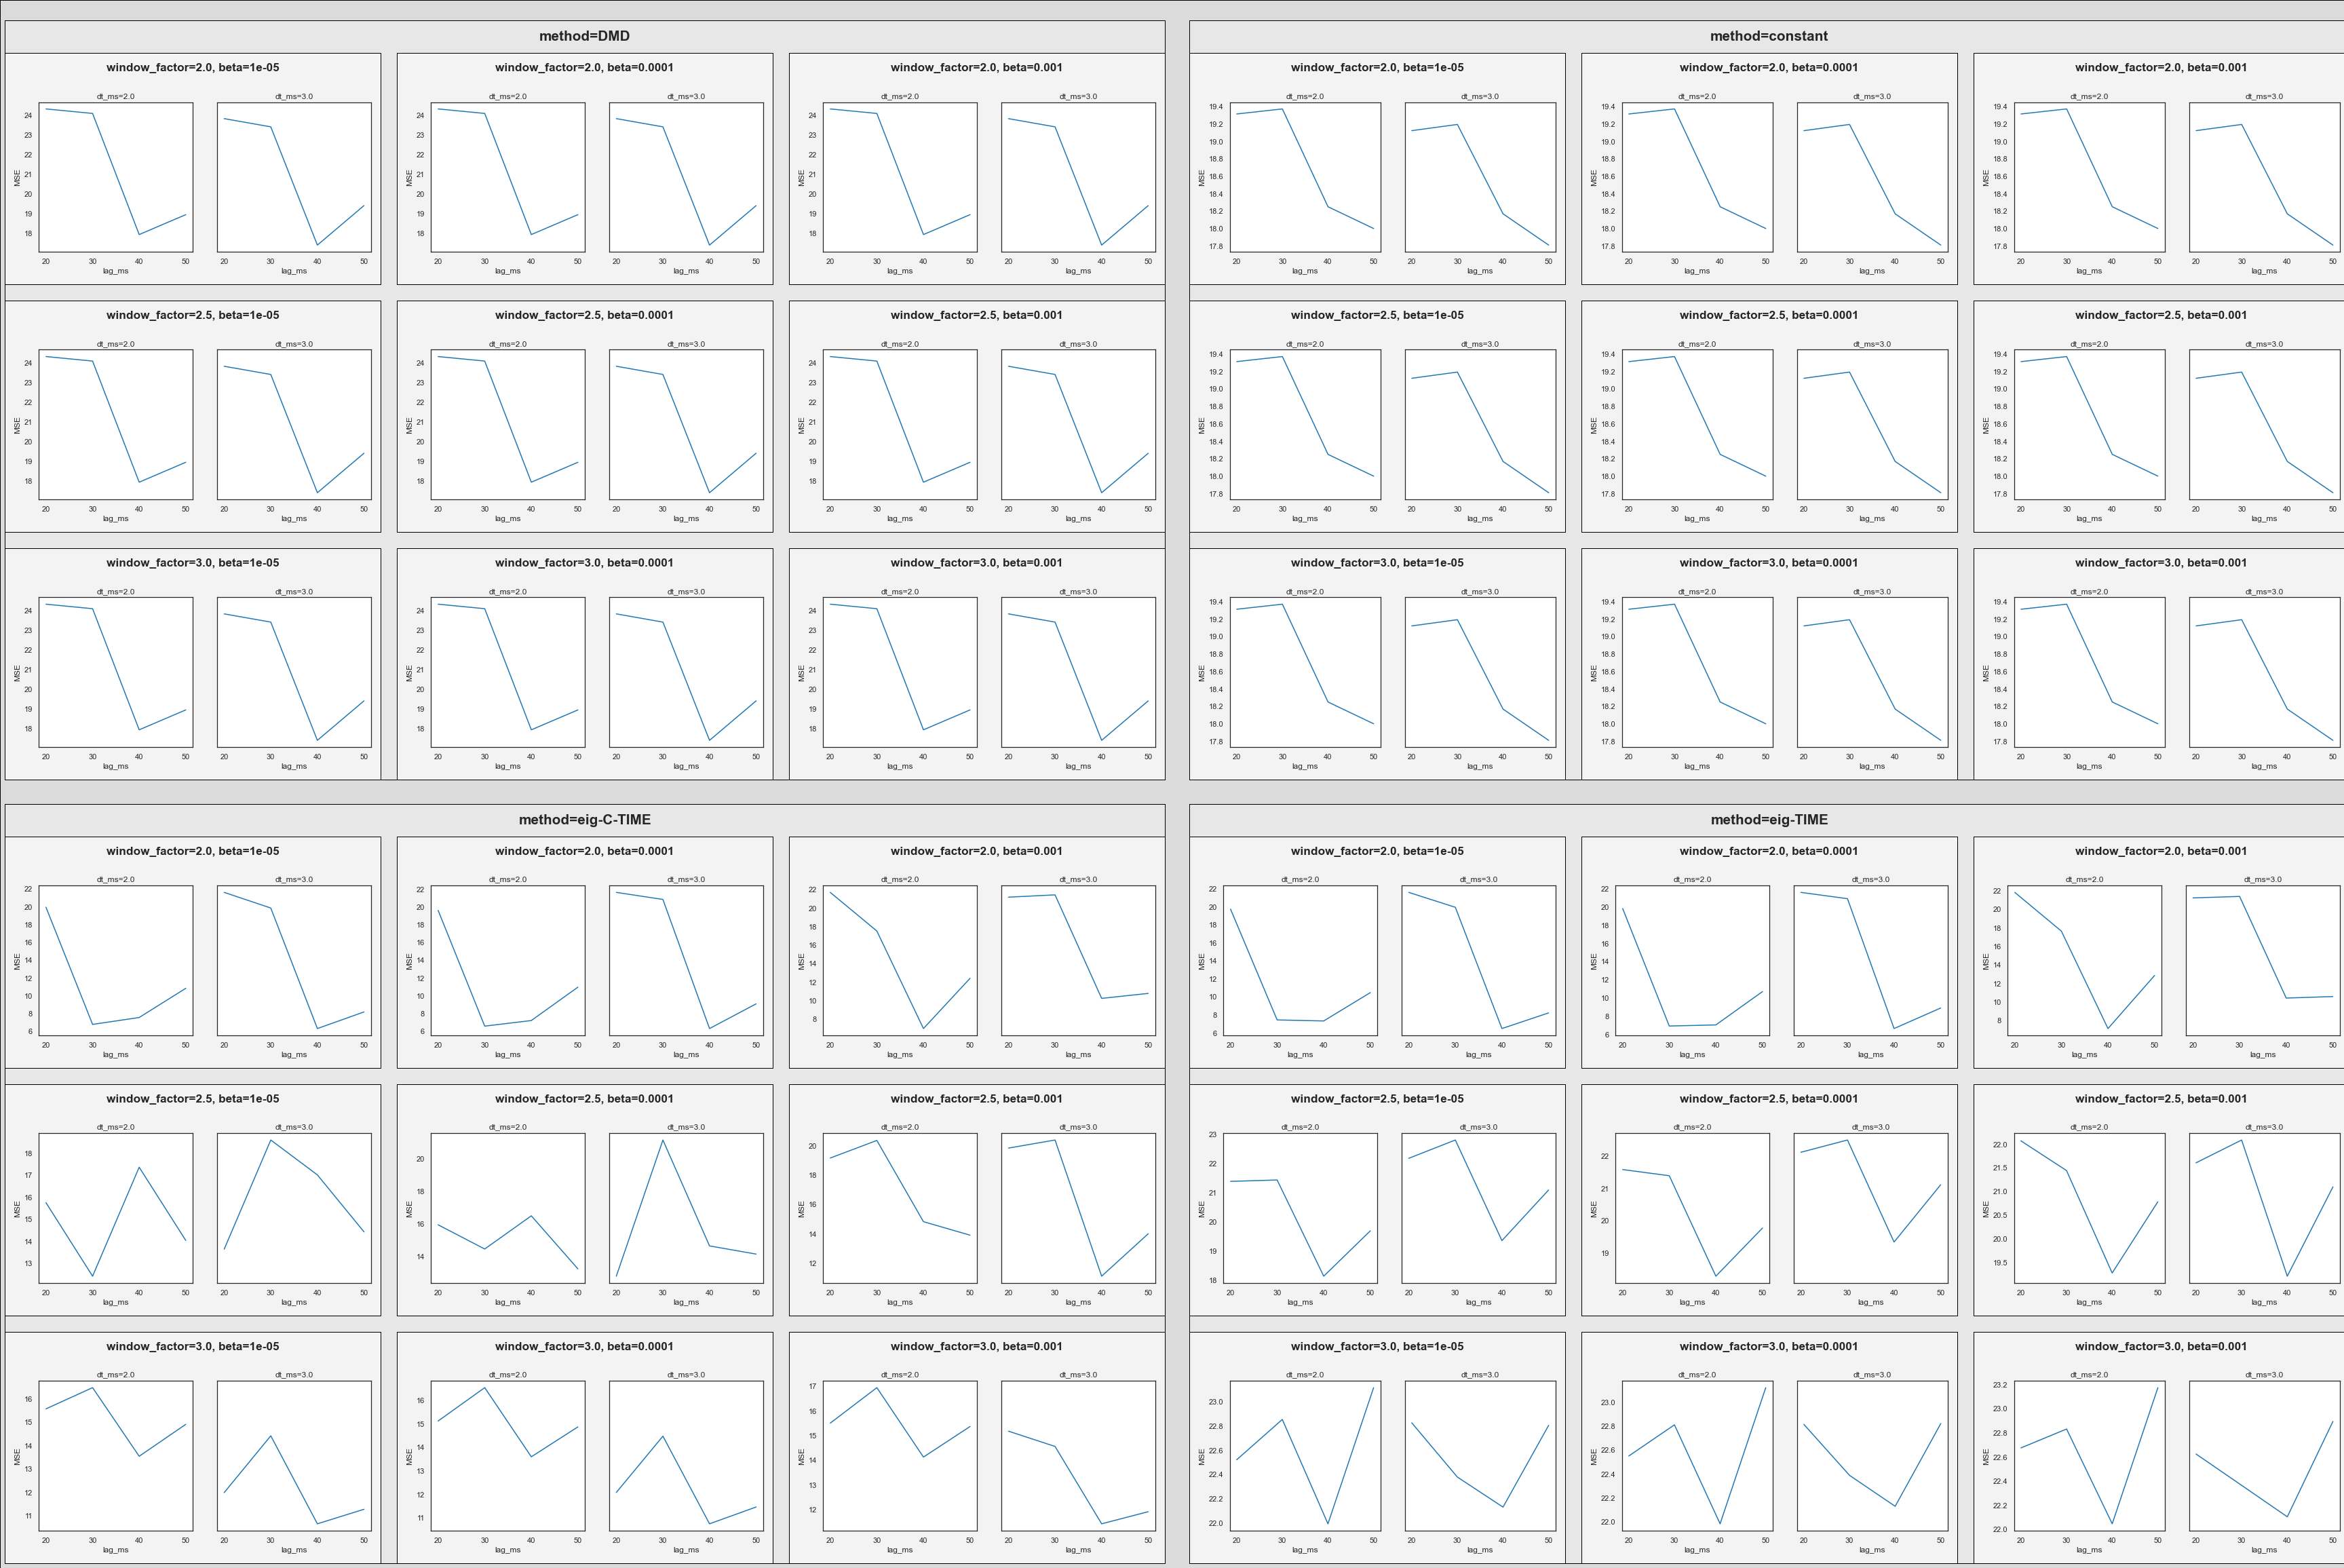

In [545]:
plotter = lambda df, ax: sns.lineplot(x ='lag_ms', y ='MSE', markers=True, data=df, ax=ax)
plot_dataframe3(results, plotter, layers=['method', ['window_factor', 'beta'], 'dt_ms'], figures=False, stroke=True, size=(4,4))


In [ ]:
fig = plt.figure(constrained_layout=True)
sub = fig.subfigures(2, 1).flat[0]
print(dir(sub))


0.004968881607055664
0.00327301025390625
0.00298309326171875
0.0035660266876220703
0.003267049789428711
0.002795696258544922
0.002894163131713867
0.003303050994873047
0.0032722949981689453
0.004701852798461914
0.0031681060791015625
0.00409388542175293
0.0031223297119140625
0.0031278133392333984
0.0027358531951904297
0.0026149749755859375
0.002560138702392578
0.0026340484619140625
0.0025701522827148438
0.002699136734008789
0.0026121139526367188
0.002744913101196289
0.002565145492553711
0.002888917922973633


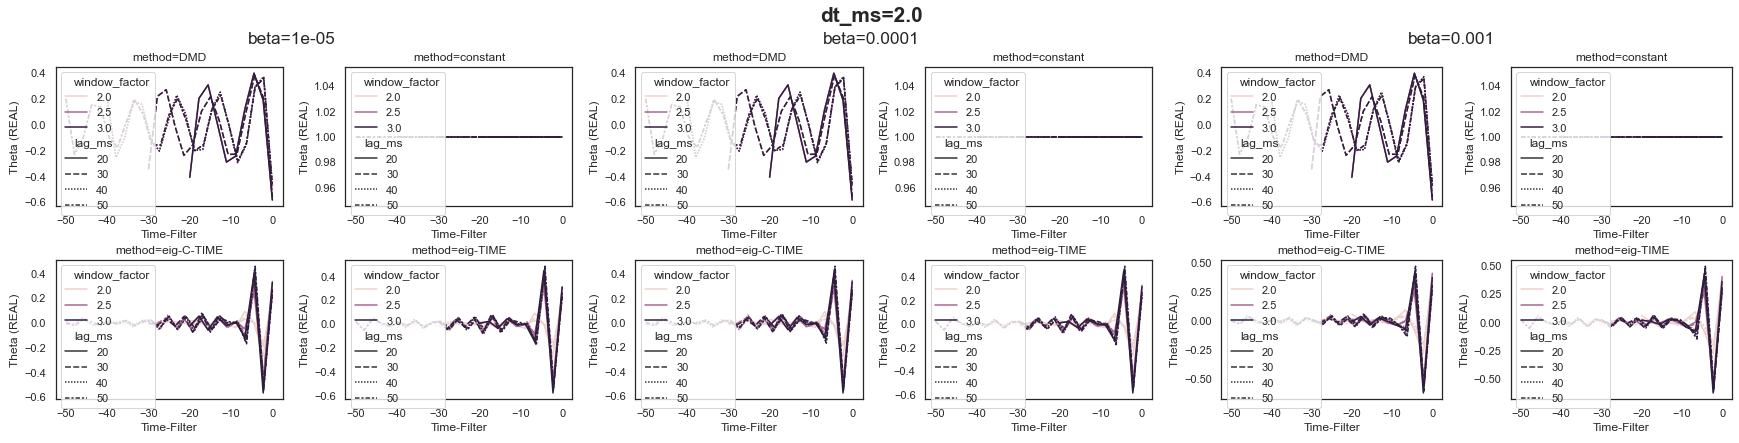

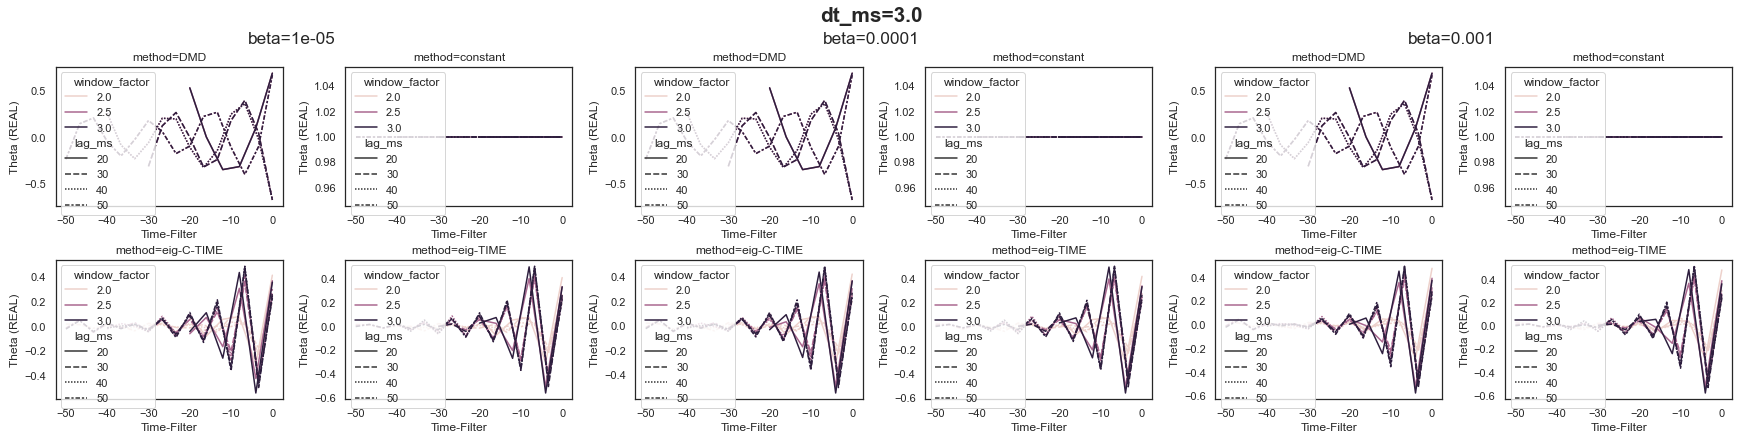

In [124]:
import time

def flatten_cols(df, cols):
    recs = df.to_dict('records')
    new_records = []
    for r in recs:
        serieses = [r[c] for c in cols]
        for pts in zip(*serieses):
            new_d = {}
            for k, pt in zip(cols, pts):
                new_d[k] = pt
            new_r = {**r, **new_d}
            new_records.append(new_r)

    df = pd.DataFrame(new_records)
    return df


def test_plt(df, ax):
    xk = 'Time-Filter'
    yk = 'Theta (REAL)'
    
    df = flatten_cols(df, [xk, yk])

    sns.lineplot(x = xk, y =yk, hue='window_factor', style='lag_ms', data=df, ax=ax)

plot_dataframe2(results, test_plt, figures=['dt_ms'], plots=['beta'], subplots=['method'])
